# Simulating JWST/MIRI spectra of rocky exoplanet surface (a complete walkthrough)

Plan:

1. Model equations
2. Simple simulation example with basalt and some planetary parameters
3. Comparison of reflected and emitted components
4. JWST simulation with pandexo

In [1]:
# import area

import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi 
import pandexo.engine.justplotit as jpi
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import astropy
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter, NullFormatter
from scipy.ndimage import gaussian_filter1d as gauss_conv
import pickle as pk
import numpy as np
import pandas as pd
import scipy.constants as sc
from spectres import spectres 
import copy
import pysynphot as psyn

import matplotlib

## The model

The thermally emitted planetary flux $F_{p}$ from an exoplanet can be written as:
$$F_p = \Big(\dfrac{R_p}{D}\Big)^2 (\int_{-\pi/2}^{\pi/2}\int_{-\pi/2}^{\pi/2} \epsilon_\lambda B_\lambda[T(\theta,\phi)] \textrm{cos}^2\theta \textrm{cos}\phi d\theta d\phi)$$

where $R_{p}$ is the radius of the planet, $D$ is the distance from us to the planet, $I_s$ is the intensity of the reflected or scattered light, $\epsilon_{\lambda}$ is the emissivity of the surface, $B_{\lambda}$ is the blackbody radiance function, $\theta$ is the latitude and $\phi$ is the longitude on the planet. By Kirchoff's law, $\epsilon = 1 - r_h$, where $r_h$ is the directional hemispherical reflectance. $r_h$, by definition (the ratio of light reflected all across the hemisphere from a patch, to the light falling on the patch from a particular direction), and hence $\epsilon$, depends on the incidence angle. However, *here we are assuming a uniform $r_h$ as it was only measured at one angle in the lab*.

For temperature  $T$ of the planetary surface, there are different treatments possible:

1) a constant value throughout, such that $T$ is independent of $(\theta, \phi)$. One value for this constant temperature can be the equilibrium temperature of the planet, which goes as $T_*\sqrt{R_*/2 D_p} (1 - A)^{0.25}$, where $A$ is the albedo of the planet. 

2) highest at the substellar point and decreases as you move away. From [Cowan & Agol (2018)](https://arxiv.org/pdf/1011.0428.pdf), this dependence would look like $T(\theta, \phi) = T_{sub}(\textrm{cos}(\theta)\textrm{cos}(\phi))^{1/4}$, where $T_{sub}$ is the temperature is at the substellar point.

Using $F_* = F_{inc} (D_p/D)^2$, where $F_{inc} = \pi I_\lambda (R_*/D_p)^2$, we can calculate $F_p/F_*$:

$$\dfrac{F_p}{F_*} = \Big(\dfrac{R_p}{D_p}\Big)^2 \Big(\dfrac{\int_{-\pi/2}^{\pi/2} \int_{-\pi/2}^{\pi/2} \epsilon_\lambda B_\lambda[T(\theta, \phi)] \textrm{cos}^2\theta \textrm{cos}\phi d\theta d\phi}{\pi I_\lambda (R_*/D_p)^2}\Big)$$

where $R_*$ is the stellar radius, $D_p$ is the distance between the star and the planet. $I_\nu$ is the stellar spectral radiance. If the star is assumed to be a blackbody, then $I_{\nu} = B_\lambda (T_*)$. Otherwise we will be using an appropriate stellar spectral radiance model. The stellar model files are usually in the units of Jansky, i.e., [spectral flux density](https://www.cv.nrao.edu/~sransom/web/Ch2.html). Spectral flux density $F_{\lambda}$ is the integral of spectral radiance $I_\lambda$ over a hemisphere: $F_\lambda = \int I_\lambda$ cos $\theta d\Omega = \pi I_\lambda$. So we can get the spectral radiance by dividing the stellar models (which are in units of Jansky) by $\pi$.

### Let's gather all the parameters needed for the model equation, considering the case of LHS-3844b and a basalt like surface

First, let's define the planetary parameters. We will assume a constant equilibrium temperature for the planet. Let's try two different values, one the equilibrium temperature with basalt's albedo, and second the dayside temperature measured by Kreidberg et al. (2019) 

In [4]:
R_p = 0.116*7.1492*10**7   # planetary radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al.
D_p = 7.039*R_star
T_star = 3036    # stellar temperature in K
T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)

A_basalt = 0
T_eq = T_star*np.sqrt(R_star/(2*D_p))*(1 - A_basalt)**(0.25)

# load emissivity data

eps_basalt = np.loadtxt('data_Emily/basalt.csv', delimiter=',')
wav_basalt, eps_basalt  = eps_basalt[:,0][::-1], eps_basalt[:,1][::-1]

Load stellar spectrum from model

In [5]:
data = np.loadtxt('Resources/LHS3844_nextgensolar_spectrum.txt', skiprows=7)
stellar_wav_n = data[:,0]
stellar_flux_n = data[:,1]

# convert wavelength axis to m

stellar_wav_n = stellar_wav_n*10**-10

# convert from erg/cm2/s/A to jy (10^-23 ergs/cm2/s/Hz)

c = 3.0e+8
stellar_flux_n = 10**23*stellar_flux_n*10**10*(stellar_wav_n)**2/c

#slice the arrays between 1 and 25 microns

stellar_wav = stellar_wav_n
stellar_flux = stellar_flux_n

ind = np.where((stellar_wav > 1.0*10**-6) & (stellar_wav < 25.0*10**-6))
stellar_wav = stellar_wav[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
stellar_flux = stellar_flux[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
stellar_flux = stellar_flux*c/(stellar_wav)**2

# convert from flux density to spectral radiance

stellar_radiance = stellar_flux/np.pi

# match the wavelength axis to the emissivity wavelength axis

stellar_radiance = spectres(wav_basalt, stellar_wav*10**6, stellar_radiance)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



Define functions to calculate blackbody radiance and the flux from the planet (numerator in the $F_p/F_*$ equation)

In [4]:
# define a function to calculate F_p/F_* at a given wavelength

def bb(wav,T):
    pi = np.pi
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity


def fp_over_fstar(wav_array,R_p, D_p, eps_array, spec_star, T_00, R_star, constant_T=False):
    
    theta_array, dtheta = np.linspace(-np.pi/2, np.pi/2,num=100, retstep=True)
    phi_array, dphi = np.linspace(-np.pi/2, np.pi/2,num=100,retstep=True)
    
    theta_mesh, phi_mesh = np.meshgrid(theta_array, phi_array)
    
    spec = np.full(wav_array.size, np.nan)
    
    for i in range(wav_array.size):
        wav = wav_array[i]
        eps = eps_array[i]
        if constant_T:
            T_mesh = T_00*np.ones(theta_mesh.shape)
        else:
            T_mesh = T_00*(np.cos(theta_mesh)*np.cos(phi_mesh))**0.25
        B_mesh = bb(wav,T_mesh)
        angles_mesh = np.cos(theta_mesh)**2*np.cos(phi_mesh)
        integral = np.sum(eps*B_mesh*angles_mesh*dtheta*dphi)
            
        spec[i] = (R_p/D_p)**2*(1 - eps + integral/(np.pi*spec_star[i]*(R_star/D_p)**2))
        
    if np.sum(np.isnan(spec)) == True:
        raise ValueError('spec has one or more nan values in it')
    else:
        return spec

Calculate and plot the basalt model

In [18]:
spec_basalt_eq = fp_over_fstar(wav_basalt*10**-6, R_p, D_p, eps_basalt, stellar_radiance, T_eq, R_star, constant_T=True)
spec_basalt_dayside = fp_over_fstar(wav_basalt*10**-6, R_p, D_p, eps_basalt, stellar_radiance, T_dayside, R_star, constant_T=True)

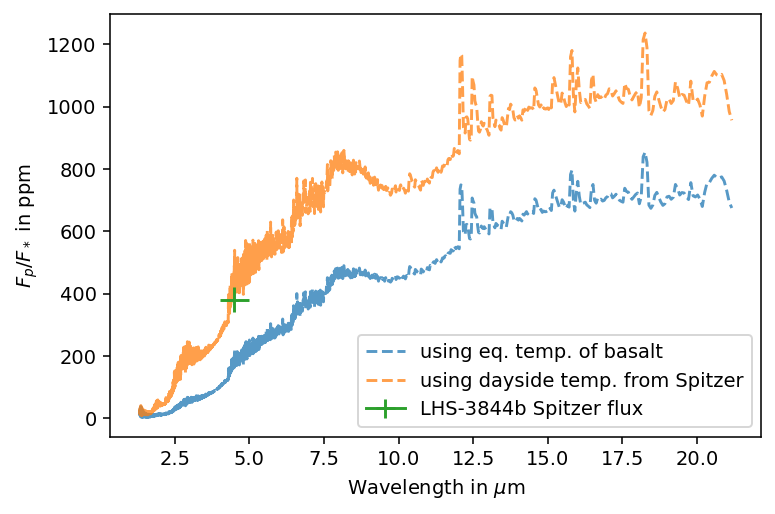

In [19]:
plt.figure()
plt.plot(wav_basalt, spec_basalt_eq*10**6, ls='--', alpha=0.75, label='using eq. temp. of basalt')
plt.plot(wav_basalt, spec_basalt_dayside*10**6, ls='--', alpha=0.75, label='using dayside temp. from Spitzer')
plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40,  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()

The dayside temperature calculation produces a better match to the Spitzer data point, but in this case we can't utilize the emissivity differences between different minerals. Let's proceed with the eq. temp. calculation since that is what we are interested in.

In [20]:
# write the model spectra into .txt files with column-1 as wavelength and column-2 as F_p/F_star

file_prefix = 'simulated_data/xrp/'
np.savetxt(file_prefix +'basalt_eq.txt', np.array([wav_basalt, spec_basalt_eq]).T, delimiter='\t', fmt='%s')

Now let's perform pandexo simulation for this data

In [21]:
# set up the run

exo_dict = jdi.load_exo_dict()

# exoplanet observation inputs

exo_dict['observation']['sat_level'] = 100    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 1 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 4*0.5212*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

# exoplanet host star inputs

exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
exo_dict['star']['starpath'] = './simulated_data/LHS3844_stellar.dat'
exo_dict['star']['w_unit'] = 'um'                      
exo_dict['star']['f_unit'] = 'Jy'      
exo_dict['star']['mag'] = 9.1            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 2.22         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

'''
exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 3036             #in K
exo_dict['star']['metal'] = 0.0             # as log Fe/H (don't know this value)
exo_dict['star']['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
'''

# exoplanet planetary inputs
exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['f_unit'] = 'fp/f*'                 # Other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.5212*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'

# basalt
exo_dict['planet']['exopath'] = './simulated_data/xrp/basalt_eq.txt'

In [22]:
# load instrument

inst_dict = jdi.load_mode_dict('MIRI LRS')

# run simulation for basalt

result = jdi.run_pandexo(exo_dict, inst_dict, output_path = './pandexo_outputs/xrp/', output_file='basalt_eq.p')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


In [19]:
R = 50

# load outputs from run

out_basalt = pk.load(open('./pandexo_outputs/xrp/basalt_eq.p','rb'))
x_basalt_5,y_basalt_5,e_basalt_5 = jpi.jwst_1d_spec(out_basalt, R=R/2, num_tran=5, model=True, plot=False)
x_basalt_10,y_basalt_10,e_basalt_10 = jpi.jwst_1d_spec(out_basalt, R=R/2, num_tran=10, model=True, plot=False)

Text(0, 0.5, 'error in ppm')

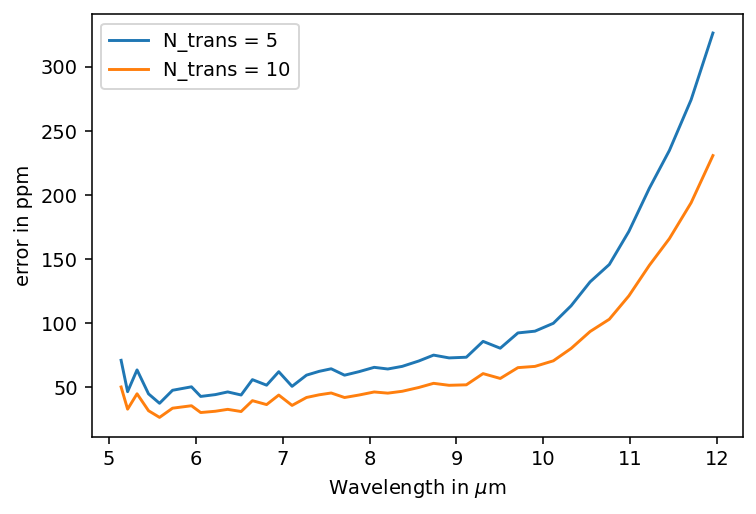

In [16]:
plt.figure()

ind = np.where(x_basalt_5[0] < 12)

plt.plot(x_basalt_5[0][ind], e_basalt_5[0][ind]*10**6, label='N_trans = 5')
plt.plot(x_basalt_10[0][ind], e_basalt_10[0][ind]*10**6, label='N_trans = 10')
plt.legend()
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('error in ppm')

(-100.0, 1000.0)

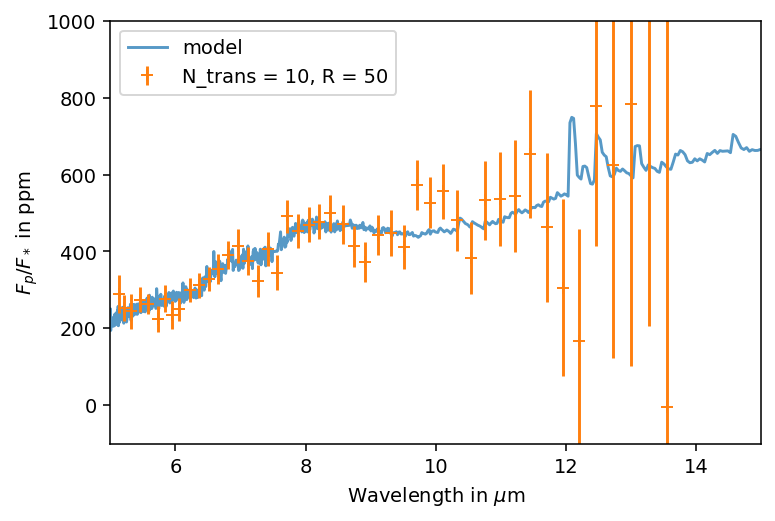

In [20]:
plt.figure()
data  = np.loadtxt('simulated_data/xrp/basalt_eq.txt')
wav_model, spec_model = data[:,0], data[:,1]
plt.plot(wav_model, spec_model*10**6, alpha=0.75, label='model')
#plt.errorbar(x_basalt_5[0],10**6*y_basalt_5[0], yerr=10**6*e_basalt_5[0], ls='', fmt='+', label='N_trans = 5, R = 50')
plt.errorbar(x_basalt_10[0],10**6*y_basalt_10[0], yerr=10**6*e_basalt_10[0], ls='', fmt='+', label='N_trans = 10, R = 50')
#plt.errorbar(x=4.5, y = 380, xerr=0.5, yerr=40,  label='LHS-3844b Spitzer flux')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.legend()

plt.xlim((5,15))
plt.ylim((-100,1000))

In [8]:
spec_model

array([1.33403077e+00, 1.70362323e-05])